In [1]:
!conda install pytorch torchvision torchaudio cudatoolkit=11.3 -c pytorch

/bin/bash: line 1: conda: command not found


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet50, ResNet50_Weights
from torchvision import transforms

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
from PIL import Image

In [3]:
print(torch.__version__)

2.8.0+cu126


In [4]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())

False
0


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
EPOCHS = 10
STEP = 10
LR = 0.1
GAMMA = 0.1
IMG_SIZE = 128
BATCH = 32
# OUT_SIZE = len(le.classes_)

In [7]:
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [8]:
class Pipeline(Dataset):
    def __init__(self, data, transform=None):
        super(Pipeline, self).__init__()
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx, 0]
        label = self.data.iloc[idx, 1]

        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)

        label = torch.tensor(label, dtype=torch.long)
        return img, label

In [9]:
from pathlib import Path

def create_df(path):
    dd = {"images": [], "labels": []}
    for label_name in os.listdir(path):
        img_dir = os.path.join(path, label_name)
        if not os.path.isdir(img_dir):
            continue  # skip non-directories (e.g., hidden files)
        for img_file in os.listdir(img_dir):
            img_path = os.path.join(img_dir, img_file)
            if os.path.isdir(img_path):
                continue
            dd["images"].append(img_path)
            dd["labels"].append(label_name)
    return pd.DataFrame(dd)


base_dir = Path("/content/drive/MyDrive/Colab Notebooks/blood_cell_images_split_90_10")
train_dir = base_dir / "train"
val_dir = base_dir / "val"

train_df = create_df(train_dir)
val_df = create_df(val_dir)

train_ds = Pipeline(train_df, transform)
val_ds = Pipeline(val_df, transform)

In [10]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train_df["labels"] = le.fit_transform(train_df["labels"])
val_df["labels"] = le.transform(val_df["labels"])

In [11]:
def create_df(path):
    path = Path(path)
    images = []
    labels = []
    valid_exts = {".jpg", ".jpeg", ".png", ".bmp"}

    # Traverse each class folder (e.g., basophil, seg_neutrophil, etc.)
    for label_dir in path.iterdir():
        if not label_dir.is_dir():
            continue  # skip non-folder items

        # Collect image files inside each class folder
        for img_path in label_dir.glob("*"):
            if img_path.is_file() and img_path.suffix.lower() in valid_exts:
                images.append(str(img_path))
                labels.append(label_dir.name)
            else:
                # Skip subdirectories or non-image files
                continue

    df = pd.DataFrame({"images": images, "labels": labels})
    print(f" Created dataframe from {path}")
    print(f"   Total image files found: {len(df)}")
    return df

In [12]:
train_dir = "/content/drive/MyDrive/Colab Notebooks/blood_cell_images_split_90_10/train"
val_dir = "/content/drive/MyDrive/Colab Notebooks/blood_cell_images_split_90_10/val"

train_df = create_df(train_dir)
val_df = create_df(val_dir)

# Encode string labels to numeric
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train_df["labels"] = le.fit_transform(train_df["labels"])
val_df["labels"] = le.transform(val_df["labels"])

 Created dataframe from /content/drive/MyDrive/Colab Notebooks/blood_cell_images_split_90_10/train
   Total image files found: 4500
 Created dataframe from /content/drive/MyDrive/Colab Notebooks/blood_cell_images_split_90_10/val
   Total image files found: 500


In [13]:
# Create dataset pipelines (if you’re using transforms)
train_ds = Pipeline(train_df, transform)
val_ds = Pipeline(val_df, transform)

# Create DataLoaders
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=0)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=0)

In [14]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train_df["labels"] = le.fit_transform(train_df["labels"])
val_df["labels"] = le.transform(val_df["labels"])

OUT_SIZE = len(le.classes_)
print("Number of classes (OUT_SIZE):", OUT_SIZE)

Number of classes (OUT_SIZE): 5


In [15]:
# resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
resnet = resnet50(weights=None)
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, OUT_SIZE)

class ResNet(nn.Module):
    def __init__(self, model):
        super(ResNet, self).__init__()
        self.model = model

    def forward(self, x):
        return self.model(x)
        # return nn.functional.softmax(self.model(x), dim=1)

# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"

model = ResNet(resnet)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

In [16]:
# best_model = deepcopy(model)
# best_model = deepcopy(model.cpu()).to(device)
best_model = model
best_acc = 0

train_loss = []
train_acc = []
val_loss = []
val_acc = []

In [17]:
print(len(train_dl))
print(len(val_dl))
print(train_dl.batch_size)

141
16
32


In [18]:
print(f"Dataset size: {len(train_dl.dataset)}")
print(type(train_dl.dataset))

Dataset size: 4500
<class '__main__.Pipeline'>


In [19]:
def train_one_epoch(model, train_dl, optimizer, criterion, device):
    model.train()
    diff = 0
    acc = 0
    total = 0

    for data, target in train_dl:
        optimizer.zero_grad()
        if device == "cuda":
            data, target = data.cuda(), target.cuda()
        # print(data.shape, target.shape)

        out = model(data)
        loss = criterion(out, target)
        diff += loss.item()
        acc += (out.argmax(1) == target).sum().item()
        total += out.size(0)

        loss.backward()
        optimizer.step()

    return diff / total, acc / total

In [20]:
def validate(model, val_dl, criterion, device):
    model.eval()
    diff = 0
    acc = 0
    total = 0

    with torch.no_grad():
        for data, target in val_dl:
            if device == "cuda":
                data, target = data.cuda(), target.cuda()

            out = model(data)
            loss = criterion(out, target)
            diff += loss.item()
            acc += (out.argmax(1) == target).sum().item()
            total += out.size(0)

    return diff / total, acc / total

In [21]:
dir_count = sum(os.path.isdir(p) for p in train_df["images"])
print(f"There are {dir_count} directory paths in train_df out of {len(train_df)} rows.")

There are 0 directory paths in train_df out of 4500 rows.


In [22]:
# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"
if device == "cuda":
    model = model.cuda()

for i in range(1, EPOCHS + 1):
    train_loss_epoch, train_acc_epoch = train_one_epoch(model, train_dl, optimizer, criterion, device)
    val_loss_epoch, val_acc_epoch = validate(model, val_dl, criterion, device)

    train_loss.append(train_loss_epoch)
    train_acc.append(train_acc_epoch)
    val_loss.append(val_loss_epoch)
    val_acc.append(val_acc_epoch)

    if val_acc[-1] >= best_acc:
        best_acc = val_acc[-1]
        best_model = deepcopy(model)

    scheduler.step()

    print(f"Epoch {i} train loss {train_loss_epoch:.4f} acc {train_acc_epoch:.4f} val loss {val_loss_epoch:.4f} acc {val_acc_epoch:.4f}")

Epoch 1 train loss 0.0701 acc 0.6380 val loss 0.0147 acc 0.7840
Epoch 2 train loss 0.0107 acc 0.8780 val loss 0.0066 acc 0.9140
Epoch 3 train loss 0.0063 acc 0.9282 val loss 0.0283 acc 0.7340
Epoch 4 train loss 0.0048 acc 0.9487 val loss 0.0078 acc 0.8900
Epoch 5 train loss 0.0043 acc 0.9562 val loss 0.0107 acc 0.8960
Epoch 6 train loss 0.0020 acc 0.9780 val loss 0.0028 acc 0.9720
Epoch 7 train loss 0.0043 acc 0.9622 val loss 0.0041 acc 0.9480
Epoch 8 train loss 0.0028 acc 0.9704 val loss 0.0033 acc 0.9640
Epoch 9 train loss 0.0016 acc 0.9849 val loss 0.0029 acc 0.9720
Epoch 10 train loss 0.0173 acc 0.8984 val loss 0.0083 acc 0.9120


In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc, classification_report

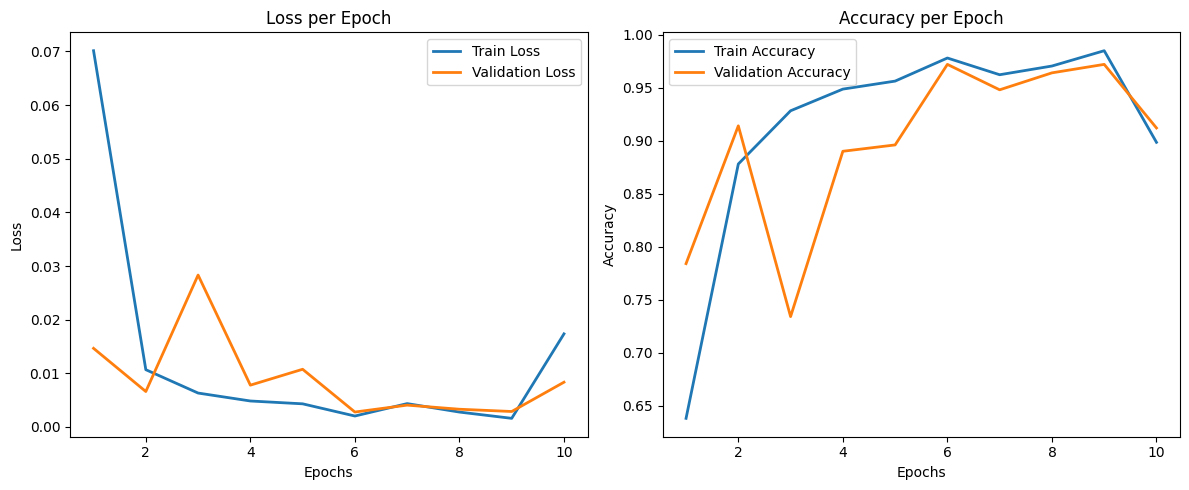

In [49]:
# 1. PLOT TRAINING AND VALIDATION LOSS & ACCURACY
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label="Train Loss", linewidth=2)
plt.plot(epochs, val_loss, label="Validation Loss", linewidth=2)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()
plt.grid(False)  # Disable background grid

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label="Train Accuracy", linewidth=2)
plt.plot(epochs, val_acc, label="Validation Accuracy", linewidth=2)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy per Epoch")
plt.legend()
plt.grid(False)  # Disable background grid

plt.tight_layout()
plt.show()

In [50]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import numpy as np
from torchvision import datasets, transforms

                 precision    recall  f1-score   support

       Basophil       1.00      0.82      0.90       100
   Erythroblast       0.87      1.00      0.93       100
       Monocyte       1.00      0.01      0.02       100
     Myeloblast       0.64      0.83      0.72       100
Seg. Neutrophil       0.57      0.99      0.73       100

       accuracy                           0.73       500
      macro avg       0.82      0.73      0.66       500
   weighted avg       0.82      0.73      0.66       500

Confusion Matrix:
[[ 82  15   0   2   1]
 [  0 100   0   0   0]
 [  0   0   1  43  56]
 [  0   0   0  83  17]
 [  0   0   0   1  99]]


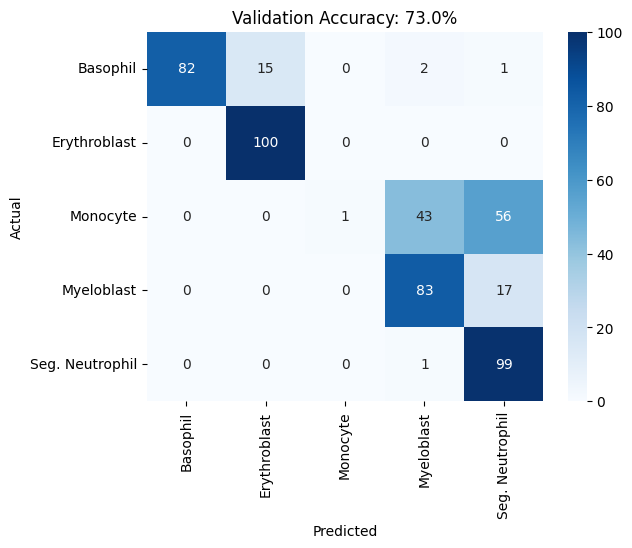

In [60]:
# Paths
base_dir = Path("/content/drive/MyDrive/Colab Notebooks/blood_cell_images_split_90_10")
train_dir = base_dir / "train"
val_dir = base_dir / "val"

# Define transforms (must match your training transform!)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load validation dataset
val_dataset = datasets.ImageFolder(val_dir, transform=transform)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False)

# Class label mapping
label_mapping = {
    4: "Basophil",
    3: "Erythroblast",
    0: "Monocyte",
    1: "Myeloblast",
    2: "Seg. Neutrophil"
}

# Desired order of class indices and names
ordered_indices = [4, 3, 0, 1, 2]
ordered_names = [label_mapping[i] for i in ordered_indices]

# Prediction function
def predict(img_tensor):
    img_tensor = img_tensor.view(1, 3, 224, 224)
    best_model.eval()
    with torch.no_grad():
        if torch.cuda.is_available():
            img_tensor = img_tensor.cuda()
        out = best_model(img_tensor)
    index = out.argmax(1).item()
    return index, round(out[0][index].item() * 100, 2)

# Evaluation loop
truth, preds, probas = [], [], []

for img, label in val_loader:
    pred, proba = predict(img)
    preds.append(pred)
    truth.append(label.item())
    probas.append(proba)

# Classification metrics
score = accuracy_score(truth, preds)
print(classification_report(truth, preds, labels=ordered_indices, target_names=ordered_names))

# Confusion matrix
cm = confusion_matrix(truth, preds, labels=ordered_indices)
print("Confusion Matrix:")
print(cm)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=ordered_names, yticklabels=ordered_names)
plt.title(f"Validation Accuracy: {round(score * 100, 2)}%")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [61]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from torchvision import datasets, transforms
from sklearn.preprocessing import label_binarize
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

In [63]:
# 1. Calculate overall metrics
precision = precision_score(truth, preds, average='weighted')
recall = recall_score(truth, preds, average='weighted')
f1 = f1_score(truth, preds, average='weighted')

print("\n===== Evaluation Metrics =====")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-Score : {f1:.4f}")


===== Evaluation Metrics =====
Accuracy : 0.9120
Precision: 0.8170
Recall   : 0.7300
F1-Score : 0.6603


In [64]:
# 2. ROC curve (multi-class)
# Re-run model to get raw probability outputs for ROC
best_model.eval()
all_probs = []

with torch.no_grad():
    for img, _ in val_loader:
        if torch.cuda.is_available():
            img = img.cuda()
        out = best_model(img)
        probs = torch.nn.functional.softmax(out, dim=1).cpu().numpy()
        all_probs.append(probs[0])

all_probs = np.array(all_probs)

# Binarize labels (needed for multi-class ROC)
n_classes = len(val_dataset.classes)
truth_bin = label_binarize(truth, classes=list(range(n_classes)))

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(truth_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

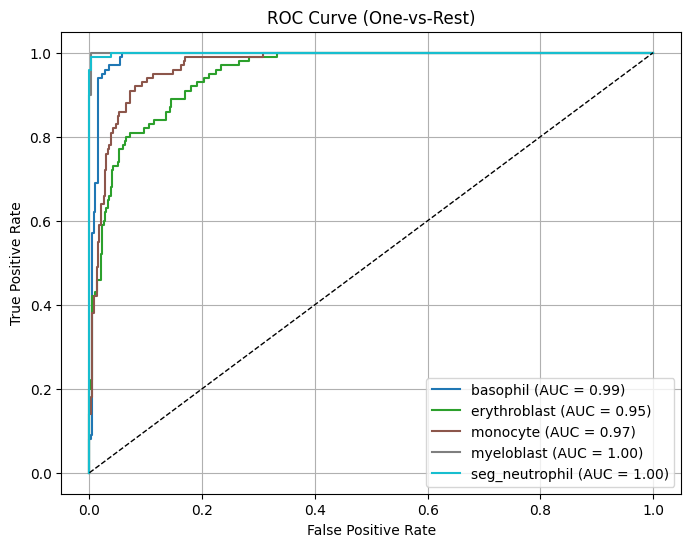

In [65]:
# 3. Plot ROC curves
plt.figure(figsize=(8, 6))
colors = plt.cm.get_cmap("tab10", n_classes)

for i, class_name in enumerate(val_dataset.classes):
    plt.plot(fpr[i], tpr[i],
             label=f"{class_name} (AUC = {roc_auc[i]:.2f})",
             color=colors(i))

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (One-vs-Rest)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()